In [1]:
from helper_functions import read_helm_list, rank_questions, visualize_response_trends, calculate_ranked_results, load_or_calculate_results
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np
import seaborn as sns
from tabulate import tabulate
import pickle

# Debugging `analysis.txt` file formatting

In [17]:
runs = '/nlp/scr4/nlp/crfm/yifanmai/helm-release/benchmark_output/runs/'
version = 'v1.0.0/'
instance = 'commonsense:dataset=openbookqa,method=multiple_choice_joint,model=01-ai_yi-34b/'
path = runs + version + instance

# several json files to choose from in each directory, pick the appropriate ones
relevant_files = {'display_predictions': ['instance_id', 'predicted_text', 'stats'],
'instances': ['id', 'input', 'references']}

relevant_files = {'display_predictions': ['instance_id', 'predicted_text', 'stats'],
    'instances': ['id', 'input', 'references']}
    
df_list = []
for file in relevant_files.keys():
    with open(path + file + '.json') as json_file:
        full_dict = json.load(json_file)
    
    if file == 'instances':
        # Process instances file differently to handle references
        processed_records = []
        for record in full_dict:
            # Start with the basic record info
            processed_record = {
                'id': record['id'],
                'input': record['input']
            }
            
            # Process references by combining text and tags
            reference_texts = []
            for ref in record['references']:
                text = ref['output']['text']
                tags = ref['tags']
                if tags:  # Only add tags if they exist
                    text = f"{text} ({', '.join(tags)})"
                reference_texts.append(text)
            
            # Join all references with newlines
            processed_record['references'] = 'SALILSPLITCHECK'.join(reference_texts)
            processed_records.append(processed_record)
            
        df_temp = pd.json_normalize(processed_records)
        df_temp = df_temp.rename(columns={'id': 'instance_id'})
    else:
        only_relevant_keys = [{key: record[key] for key in relevant_files[file]} for record in full_dict]
        df_temp = pd.json_normalize(only_relevant_keys)
        
    df_list.append(df_temp)

In [20]:
sample_row = df_list[1].iloc[0]
sample_row 

instance_id                                               id4957
references     make more phone callsSALILSPLITCHECKquit eatin...
input.text     A person wants to start saving money so that t...
Name: 0, dtype: object

In [21]:
references = sample_row['references'].split('SALILSPLITCHECK')
formatted_references = '\n'.join(f"Reference {i+1}: {ref}" for i, ref in enumerate(references))
print(formatted_references)

Reference 1: make more phone calls
Reference 2: quit eating lunch out (correct)
Reference 3: buy less with monopoly money
Reference 4: have lunch with friends


In [2]:
runs = '/nlp/scr4/nlp/crfm/yifanmai/helm-release/benchmark_output/runs/'
version = 'v1.0.0/'
instance = 'commonsense:dataset=openbookqa,method=multiple_choice_joint,model=01-ai_yi-34b/'
path = runs + version + instance

# several json files to choose from in each directory, pick the appropriate ones
relevant_files = {'display_predictions': ['instance_id', 'predicted_text', 'stats'],
'instances': ['id', 'input', 'references']}

df_list = []
for file in relevant_files.keys():
    with open(path + file + '.json') as json_file:
        full_dict = json.load(json_file)
    
    only_relevant_keys = [{key: record[key] for key in relevant_files[file]} for record in full_dict]

    # df_temp = pd.json_normalize(only_relevant_keys)
    # if file=='instances':
        # df_temp = pd.json_normalize(only_relevant_keys)
        # df_temp = df_temp.rename(columns={'id': 'instance_id'})
    df_list.append(only_relevant_keys)

In [3]:
references_data = []
for item in df_list[1]:
    for ref in item['references']:
        ref_dict = {
            'instance_id': item['id'],
            'reference_text': ref['output']['text'],
            'reference_tags': ref['tags']
        }
        references_data.append(ref_dict)

In [4]:
pd.DataFrame(references_data)

,instance_id,reference_text,reference_tags
0,id4957,make more phone calls,[]
1,id4957,quit eating lunch out,[correct]
2,id4957,buy less with monopoly money,[]
3,id4957,have lunch with friends,[]
4,id4958,a marsh,[correct]
...,...,...,...
1995,id5455,a lot of tiny pebbles,[]
1996,id5456,cold,[]
1997,id5456,water,[]
1998,id5456,heat,[correct]


In [26]:
df_list[1]

[{'id': 'id4957',
  'input': {'text': 'A person wants to start saving money so that they can afford a nice vacation at the end of the year. After looking over their budget and expenses, they decide the best way to save money is to'},
  'references': [{'output': {'text': 'make more phone calls'}, 'tags': []},
   {'output': {'text': 'quit eating lunch out'}, 'tags': ['correct']},
   {'output': {'text': 'buy less with monopoly money'}, 'tags': []},
   {'output': {'text': 'have lunch with friends'}, 'tags': []}]},
 {'id': 'id4958',
  'input': {'text': 'There is most likely going to be fog around:'},
  'references': [{'output': {'text': 'a marsh'}, 'tags': ['correct']},
   {'output': {'text': 'a tundra'}, 'tags': []},
   {'output': {'text': 'the plains'}, 'tags': []},
   {'output': {'text': 'a desert'}, 'tags': []}]},
 {'id': 'id4959',
  'input': {'text': 'Predators eat'},
  'references': [{'output': {'text': 'lions'}, 'tags': []},
   {'output': {'text': 'humans'}, 'tags': []},
   {'output'

In [14]:
df = read_helm_list(version='v1.0.0/', 
                    instance='commonsense:dataset=openbookqa,method=multiple_choice_joint,model=01-ai_yi-34b/')
df.head()


,instance_id,predicted_text,stats.num_prompt_tokens,stats.num_output_tokens,stats.inference_runtime,stats.num_train_instances,stats.prompt_truncated,stats.exact_match,references,input.text
0,id4957,B,291.0,1.0,0.562962,5.0,0.0,1.0,"[{'output': {'text': 'make more phone calls'},...",A person wants to start saving money so that t...
1,id4958,A,255.0,1.0,0.340251,5.0,0.0,1.0,"[{'output': {'text': 'a marsh'}, 'tags': ['cor...",There is most likely going to be fog around:
2,id4959,C,243.0,1.0,0.297457,5.0,0.0,1.0,"[{'output': {'text': 'lions'}, 'tags': []}, {'...",Predators eat
3,id4960,C,286.0,1.0,0.304056,5.0,0.0,1.0,"[{'output': {'text': 'roots may be split'}, 't...",Oak tree seeds are planted and a sidewalk is p...
4,id4961,B,249.0,1.0,0.554581,5.0,0.0,0.0,"[{'output': {'text': 'gasoline'}, 'tags': []},...",An electric car runs on electricity via


In [4]:
versions = [f'v1.{str(i)}.0/' for i in range(14)]

In [5]:
runs = '/nlp/scr4/nlp/crfm/yifanmai/helm-release/benchmark_output/runs/'

In [6]:
version = versions[0]
for instance_df in os.listdir(runs + version):
        if instance_df == 'eval_cache':
            continue
        print(instance_df)
        break

legalbench:subset=international_citizenship_questions,model=tiiuae_falcon-7b


In [12]:
# First, let's extract benchmark from instance string
def get_benchmark(instance_string):
    # Split on 'model=' and take everything before it
    return instance_string.split('model=')[0].strip(',')

def get_model_from_instance(instance_string):
    if 'model=' in instance_string:
        return instance_string.split('model=')[1].split(',')[0].strip()
    return None

# Group dataframes by benchmark

benchmark_to_dfs = {}
benchmark_to_model = {}  # New dictionary to store model names

for version in versions[:1]:
    for instance_df in os.listdir(runs + version):
        if instance_df == 'eval_cache':
            continue
        
        df_1 = read_helm_list(version=version, instance=instance_df + '/')
        
        benchmark = get_benchmark(instance_df)
        model = get_model_from_instance(instance_df)
        
        if benchmark not in benchmark_to_dfs:
            benchmark_to_dfs[benchmark] = []
            benchmark_to_model[benchmark] = []
        benchmark_to_dfs[benchmark].append(df_1)
        benchmark_to_model[benchmark].append(model)

# Debugging agreement level and avg. score histogram

Issue: only medium and low categories are usually showing up when the agreement levels are hard-coded as high 0-00.15 std, medium = 0.15-0.30 std, low = >0.30 std. But high category should be showing up as well.

In [7]:
versions = [f'v1.{str(i)}.0/' for i in range(14)]
runs = '/nlp/scr4/nlp/crfm/yifanmai/helm-release/benchmark_output/runs/'

analysis_dir = 'analysis_output'
# output_dir = os.path.join(analysis_dir, '04122025_4_better_processed_json_references')

RANKED_RESULTS_FILE = os.path.join(analysis_dir, 'ranked_results.pkl')
BENCHMARK_MODEL_FILE = os.path.join(analysis_dir, 'benchmark_to_model.pkl')

metrics = [
    'stats.bleu_4',
    'stats.exact_match',
    'stats.math_equiv_chain_of_thought',
    'stats.f1_score',
    'stats.final_number_exact_match',
    'stats.quasi_exact_match'
]

# Load or calculate the results
ranked_results, benchmark_to_model = load_or_calculate_results(metrics, runs, versions, RANKED_RESULTS_FILE, BENCHMARK_MODEL_FILE)


Calculating results because nothing cached found...
Finished calculating results


In [8]:
benchmark = 'gsm:'
ranked_df = ranked_results[benchmark]

# Get the model name from our stored mapping
model_names = []
if benchmark in benchmark_to_model and benchmark_to_model[benchmark]:
    model_names = benchmark_to_model[benchmark]  # Already a list of model names
    # print(f"Models identified: {model_names}")

metric_name = None
# assumes only 1 metric is used per benchmark in the HELM LITE dataframes
for possible_metric in metrics:
    if any(col.startswith(possible_metric) for col in ranked_df.columns):
        metric_name = possible_metric
        break

In [9]:
std_ranges = [0, 0.15, 0.30, float('inf')]
benchmark_df = ranked_df.copy()
benchmark_df['agreement_level'] = pd.cut(benchmark_df['std'], 
                                           bins=std_ranges,
                                           labels=['High', 'Medium', 'Low'],
                                           include_lowest=True)
metric_cols = [col for col in benchmark_df.columns if col.startswith(metric_name + '_')]

In [10]:
benchmark_df.head()

,instance_id,input.text,references,predicted_text_0,stats.final_number_exact_match_0,predicted_text_1,stats.final_number_exact_match_1,predicted_text_2,stats.final_number_exact_match_2,predicted_text_3,...,predicted_text_26,stats.final_number_exact_match_26,predicted_text_27,stats.final_number_exact_match_27,predicted_text_28,stats.final_number_exact_match_28,predicted_text_29,stats.final_number_exact_match_29,std,agreement_level
0,id7473,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,Janet eats 3 eggs for breakfast and bakes 4 eg...,1.0,Janet has 16 eggs per day. She eats 3 eggs an...,1.0,She starts with 16 eggs but eats 3 for breakf...,1.0,Janet's ducks lay 16 eggs per day. \nShe eats ...,...,Janet's ducks lay 16 eggs per day. She eats t...,1.0,"Janet sells the eggs for $2 each, so she make...",0.0,She sells 16 eggs per day * $2/egg = <<16*2=3...,0.0,Janet's ducks lay 16 eggs per day. She uses 3 ...,1.0,NaN,NaN
1,id7474,A robe takes 2 bolts of blue fiber and half th...,It takes 2/2=<<2/2=1>>1 bolt of white fiber So...,The robe takes 2 bolts of blue fiber and half ...,1.0,2 bolts of blue fiber + 1 bolt of white fiber...,1.0,It takes 2/2=<<1>>1 bolt of white fiber. So i...,1.0,Let's break this down step-by-step:\n* A robe ...,...,It takes 2 bolts of blue fiber and half that ...,1.0,The blue fiber is 2 bolts * 2/3 = <<2*2/3=1.5...,0.0,It takes 2 bolts of blue fiber and half that ...,1.0,A robe takes 2 bolts of blue fiber and half th...,1.0,NaN,NaN
2,id7475,Josh decides to try flipping a house. He buys...,The cost of the house and repairs came out to ...,The house is now worth 80000*1.5=<<80000*1.5=1...,0.0,"The value of the house after repairs is $80,0...",0.0,"The house increased in value by 80,000*(1+.15...",0.0,"Josh bought the house for $80,000\nHe put in $...",...,"Josh bought the house for $80,000. He put in ...",0.0,The profit is the original value of the house...,0.0,The value of the house after the repairs is $...,0.0,Josh's total investment in the house is the pu...,0.0,NaN,NaN
3,id7476,James decides to run 3 sprints 3 times a week....,He sprints 3*3=<<3*3=9>>9 times So he runs 9*6...,He runs 3 sprints * 3 times a week = <<3*3=9>>...,1.0,He runs 3 sprints * 3 times a week = <<3*3=9>...,1.0,He runs 3*60=<<3*60=180>>180 meters each time...,1.0,"James runs 3 sprints per workout, and he works...",...,He runs 3*3=<<3*3=9>>9 sprints a week. Each s...,1.0,He runs 60 meters * 3 sprints = <<60*3=180>>1...,0.0,"He runs 3 sprints 3 times a week, so he runs ...",1.0,James runs 3 sprints * 60 meters each = <<3*60...,1.0,NaN,NaN
4,id7477,"Every day, Wendi feeds each of her chickens th...","If each chicken eats 3 cups of feed per day, t...","In the morning, Wendi feeds her chickens 15 cu...",0.0,Wendi feeds her chickens a total of 15 + 25 =...,1.0,"In the morning, Wendi gives 15 cups of feed t...",0.0,"Okay, let's break this down step-by-step:\n* W...",...,"Wendi has 20 chickens, so she needs to give t...",1.0,The size of Wendi's flock is 20 chickens. In ...,0.0,"In the morning, she gives her flock of chicke...",0.0,Wendi feeds each chicken 3 cups of feed per da...,1.0,NaN,NaN


In [12]:
all_scores = []
for level in ['High', 'Medium', 'Low']:
    level_df = benchmark_df[benchmark_df['agreement_level'] == level]
    scores = level_df[metric_cols].mean(axis=1)
    all_scores.extend(scores)

# Create fixed bins across the entire range
min_score, max_score = min(all_scores), max(all_scores)
bins = np.linspace(min_score, max_score, 30)  # 20 evenly spaced bins

# Plot histograms with consistent bins
for level in ['High', 'Medium', 'Low']:
    level_df = benchmark_df[benchmark_df['agreement_level'] == level]
    scores = level_df[metric_cols].mean(axis=1)
    
    # plt.hist(scores, bins=bins, alpha=0.5, label=f"{level} (n={len(scores)})")
    std_range = (level_df['std'].min(), level_df['std'].max())
    plt.hist(scores, bins=bins, alpha=0.5, label=f"{level} (std={std_range[0]:.3f}-{std_range[1]:.3f}, n={len(scores)})")


plt.title(f'{metric_name}\nDistribution by Agreement Level', fontsize=12, pad=20)
plt.xlabel('Average Score (1 data point = 1 question)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend()

ValueError: min() iterable argument is empty

In [35]:
# benchmark_df[benchmark_df['std'] > 0.5]
row = benchmark_df[benchmark_df['instance_id']=='id7892']
row 

,instance_id,input.text,references,predicted_text_0,stats.final_number_exact_match_0,predicted_text_1,stats.final_number_exact_match_1,predicted_text_2,stats.final_number_exact_match_2,predicted_text_3,...,predicted_text_26,stats.final_number_exact_match_26,predicted_text_27,stats.final_number_exact_match_27,predicted_text_28,stats.final_number_exact_match_28,predicted_text_29,stats.final_number_exact_match_29,std,agreement_level
325,id7892,Stanley was standing on the side of the mounta...,"The elevation of Stanley's comb was 10,000 - 4...","Oliver must climb 10,000 - 3,000 - 4,000 = <<1...",1.0,"Oliver must climb 10,000 - 4,000 = <<10000-40...",0.0,The fall from the comb from Stanley's elevati...,0.0,"Stanley's comb fell 4,000 feet from Stanley's ...",...,"Stanley's comb is at an elevation of 10,000 f...",0.0,"Oliver's elevation is 3,000 feet. Stanley's c...",0.0,"The elevation of Stanley's comb is 10,000 fee...",0.0,"Stanley's comb fell to an elevation of 10,000 ...",1.0,0.504007,Low


In [37]:
score_list = []
for col in row.columns:
    if col.startswith('stats.final_number_exact_match'):
        score_list.append(row[col])
score_list
np.std(score_list)

np.float64(0.4955356249106168)

In [34]:
np.std([1 for i in range(15)] + [0 for i in range(14)])

np.float64(0.4997026464203254)

# Testing uniform random score histogram

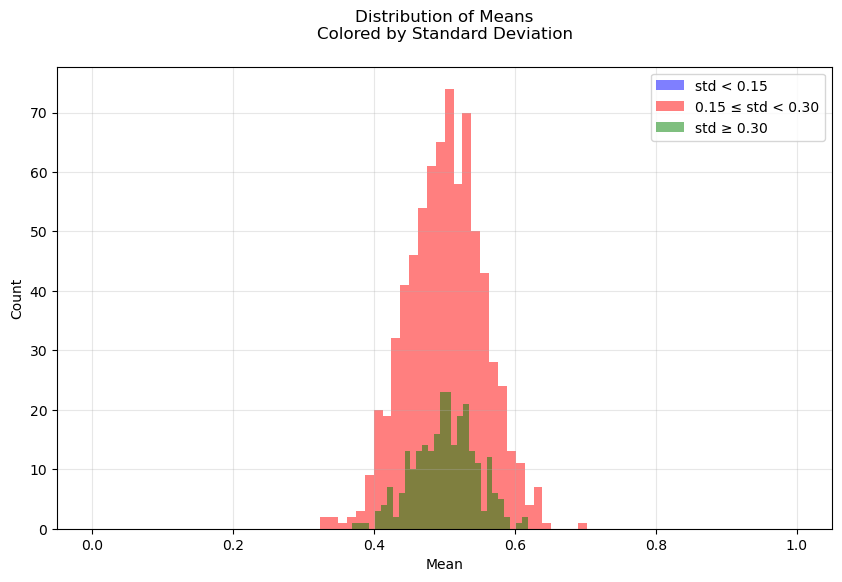

In [32]:
# generate 1000 lists of 30 numbers between 0 and 1
scores = np.random.rand(1000, 30)

# calculate the mean of each list
means = np.mean(scores, axis=1)

# calculate the std of each list
stds = np.std(scores, axis=1)

# plot histogram of means colored by std
# color values for std: blue for std < 0.15, red for std 0.15-0.30, green for std > 0.30
# plot histogram of means colored by std
plt.figure(figsize=(10, 6))

# Create masks for each std range
low_std_mask = stds < 0.15
med_std_mask = (stds >= 0.15) & (stds < 0.30)
high_std_mask = stds >= 0.30

# Plot histogram for each range
plt.hist(means[low_std_mask], bins=30, color='blue', alpha=0.5, label='std < 0.15')
plt.hist(means[med_std_mask], bins=30, color='red', alpha=0.5, label='0.15 ≤ std < 0.30')
plt.hist(means[high_std_mask], bins=30, color='green', alpha=0.5, label='std ≥ 0.30')

plt.title('Distribution of Means\nColored by Standard Deviation', fontsize=12, pad=20)
plt.xlabel('Mean', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Predict model agreement plots

In [11]:
analysis_dir = 'analysis_output'

RANKED_RESULTS_FILE = os.path.join(analysis_dir, 'ranked_results.pkl')
BENCHMARK_MODEL_FILE = os.path.join(analysis_dir, 'benchmark_to_model.pkl')

metrics = [
    'stats.bleu_4',
    'stats.exact_match',
    'stats.math_equiv_chain_of_thought',
    'stats.f1_score',
    'stats.final_number_exact_match',
    'stats.quasi_exact_match'
]
runs = '/nlp/scr4/nlp/crfm/yifanmai/helm-release/benchmark_output/runs/'
versions = ['v1.0.0/']

# Load or calculate results
ranked_results, benchmark_to_model = load_or_calculate_results(
    metrics, runs, versions, RANKED_RESULTS_FILE, BENCHMARK_MODEL_FILE
)

Calculating results because nothing cached found...
Finished calculating results


In [32]:
combined_df = pd.DataFrame()
for benchmark_name, df in ranked_results.items():
    df['benchmark'] = benchmark_name  # Add benchmark name as a column
    combined_df = pd.concat([combined_df, df], ignore_index=True)

In [35]:
ranked_results.keys()

dict_keys(['legalbench:subset=international_citizenship_questions', 'natural_qa:mode=openbook_longans', 'wmt_14:language_pair=ru-en', 'gsm:', 'math:subject=intermediate_algebra,level=1,use_official_examples=False,use_chain_of_thought=True', 'legalbench:subset=abercrombie', 'mmlu:subject=econometrics,method=multiple_choice_joint', 'math:subject=counting_and_probability,level=1,use_official_examples=False,use_chain_of_thought=True', 'natural_qa:mode=closedbook', 'math:subject=geometry,level=1,use_official_examples=False,use_chain_of_thought=True', 'wmt_14:language_pair=hi-en', 'mmlu:subject=us_foreign_policy,method=multiple_choice_joint', 'wmt_14:language_pair=cs-en', 'commonsense:dataset=openbookqa,method=multiple_choice_joint', 'math:subject=algebra,level=1,use_official_examples=False,use_chain_of_thought=True', 'legalbench:subset=function_of_decision_section', 'legalbench:subset=proa', 'med_qa:', 'wmt_14:language_pair=fr-en', 'legalbench:subset=corporate_lobbying', 'mmlu:subject=compu

In [36]:
df1 = ranked_results['gsm:']
df2 = ranked_results['natural_qa:mode=openbook_longans']
pd.concat([df1, df2], ignore_index=True)

,instance_id,input.text,references,predicted_text_0,stats.final_number_exact_match_0,predicted_text_1,stats.final_number_exact_match_1,predicted_text_2,stats.final_number_exact_match_2,predicted_text_3,...,stats.f1_score_20,stats.f1_score_21,stats.f1_score_22,stats.f1_score_23,stats.f1_score_24,stats.f1_score_25,stats.f1_score_26,stats.f1_score_27,stats.f1_score_28,stats.f1_score_29
0,id8122,Fishio posted her selfie on Instagram. She rec...,After receiving 2000 likes on her photo on Ins...,"After 3 weeks, the number of likes was 70 * 20...",0.0,"After 3 weeks, the number of likes was 70 * 2...",0.0,The number of likes after three weeks was 200...,0.0,"Okay, let's analyze this step-by-step:\n* Fish...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id8227,Lorraine and Colleen are trading stickers for ...,She trades 27 small stickers because 30 x .9 =...,Lorraine trades 30 * .9 = <<30*.9=27>>27 small...,0.0,Lorraine starts with 30 small stickers and 40...,0.0,She trades 30 small stickers * 0.9 = <<30*0.9...,0.0,"Okay, let's break this down step-by-step:",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id8125,James hires a horse-drawn carriage from 5 PM t...,He got it for 9-5=<<9-5=4>>4 hours He pays for...,The first hour is $15. The second hour is $15...,0.0,He paid for 4 hours. The first hour is $15. ...,0.0,The first paid hour is 5-1=4 so that's 15*1=$...,0.0,James gets 1 hour free from 5 PM to 6 PM.\nThe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,id8253,Ava and Emma want to know who is better at the...,"For jumping on enemies, Emma earns 8 * 10 = <<...","Ava jumps on 8 more enemies than Emma, so she ...",0.0,Let's say Emma jumps on x enemies and collect...,0.0,Ava gets 10 points + 10 points + 30 points = ...,0.0,"Okay, let's analyze this step-by-step:",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id8287,A new arcade opens up and Jack decides to play...,Jack puts change in 60/20=<<60/20=3>>3 times a...,Jack plays for 4 hours * 60 minutes / hour = <...,0.0,"Jack plays for 20 minutes per quarter, so he ...",0.0,Jack plays for 4 hours * 60 minutes/hour = <<...,0.0,Jack can play for 20 minutes per quarter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,id637,"Passage: The stratum lucidum (Latin for ""clear...","The stratum lucidum (Latin for ""clear layer"") ...",Thick skin,NaN,Stratum lucidum,NaN,stratum lucidum,NaN,Stratum lucidum,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1996,id137,Passage: \n\n\nDriver\nSeasons\nEntries\nPodiu...,Michael Schumacher (correct),Michael Schumacher,NaN,Lewis Hamilton,NaN,Not enough information to answer the above qu...,NaN,Lewis Hamilton,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1997,id2914,Passage: \n\nMichigan Wolverines men's basketb...,1989 (correct),1989,NaN,2018,NaN,2018,NaN,2017,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1998,id886,Passage: \n\nYear\nGuest name\nCountry\nNote\n...,Crown Prince Mohammed bin Zayed Al Nahyan (cor...,Crown Prince Mohammed bin Zayed Al Nahyan,NaN,Crown Prince Mohammed bin Zayed Al Nahyan,NaN,Crown Prince Mohammed bin Zayed Al Nahyan,NaN,Prime Minister Narendra Modi,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


In [28]:
def get_question_type(row):
    pred_cols = [col for col in df.columns if col.startswith('predicted_text')]
    if not pred_cols:
        print("Warning: No predicted_text columns found!")
        return 'Unknown'
        
    # Get all non-null predictions for this row
    predictions = [str(row[col]).strip() for col in pred_cols if pd.notna(row[col])]
    if not predictions:
        print(f"Warning: No valid predictions for row {row['instance_id']}")
        return 'Unknown'
        
    # Check if it's a single-letter MCQ or Yes/No question
    try:
        # is_mcq = all(len(pred) <= 1 or pred.lower() in ['yes', 'no'] for pred in predictions)
        ref = row['references']
        is_mcq = ref.lower() == 'yes (correct)' or ref.lower() == 'no (correct)'
        if is_mcq:
            return 'Single-Letter MCQ'
    except Exception as e:
        print(f"Error checking MCQ responses: {e}")
        print(f"Predictions: {predictions}")
        return 'Unknown'
        
    # Check if it's a math question (contains math symbols or LaTeX)
    if any(symbol in str(row['references']) for symbol in ['\\frac', '\\boxed', '$', '\\[', '\\]', '+', '-', '=', '^']):
        return 'Math'
    else:
        return 'Text'

In [30]:
df['question_type'] = df.apply(get_question_type, axis=1)
df.tail()

,instance_id,input.text,references,predicted_text_0,stats.quasi_exact_match_0,predicted_text_1,stats.quasi_exact_match_1,predicted_text_2,stats.quasi_exact_match_2,predicted_text_3,...,predicted_text_26,stats.quasi_exact_match_26,predicted_text_27,stats.quasi_exact_match_27,predicted_text_28,stats.quasi_exact_match_28,predicted_text_29,stats.quasi_exact_match_29,std,question_type
544,id5432,Question: Consider the country of Sweden. Does...,Yes (correct),Yes,1.0,Yes,1.0,Yes,1.0,"Yes, under the condition of being a citizen of...",...,Yes,1.0,Yes,1.0,No,0.0,No,0.0,0.508548,Single-Letter MCQ
877,id8180,Question: Consider the country of Montenegro. ...,Yes (correct),No,0.0,No,0.0,Yes,1.0,Yes,...,No,0.0,Yes,1.0,Yes,1.0,No,0.0,0.508548,Single-Letter MCQ
819,id7722,Question: Consider the country of Jordan. Does...,No (correct),Yes,0.0,No,1.0,No,1.0,Yes,...,No,1.0,No,1.0,Yes,0.0,No,1.0,0.508548,Single-Letter MCQ
557,id5519,Question: Consider the country of Syria. Does ...,No (correct),No,1.0,No,1.0,Yes,0.0,Yes,...,Yes,0.0,No,1.0,No,1.0,No,1.0,0.508548,Single-Letter MCQ
0,id102,Question: Consider the country of Albania. Doe...,Yes (correct),Yes,1.0,No,0.0,Yes,1.0,Yes,...,No,0.0,Yes,1.0,No,0.0,No,0.0,0.508548,Single-Letter MCQ



Single-Letter MCQ: 1000 questions
std range for Single-Letter MCQ: 0.000 - 0.509

Math: 0 questions

Text: 0 questions


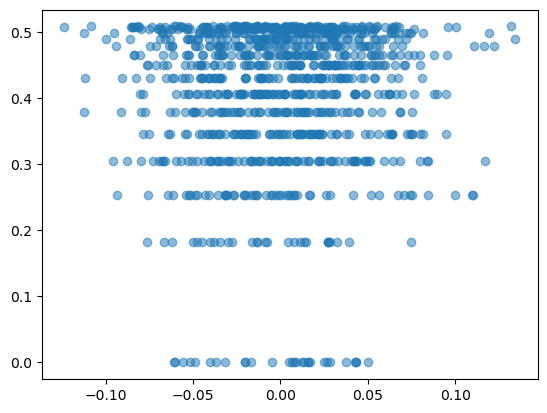

In [31]:
# Create scatter plot with jitter
for i, qtype in enumerate(['Single-Letter MCQ', 'Math', 'Text']):
    mask = df['question_type'] == qtype
    n_questions = sum(mask)
    print(f"\n{qtype}: {n_questions} questions")
    if n_questions > 0:
        print(f"std range for {qtype}: {df[mask]['std'].min():.3f} - {df[mask]['std'].max():.3f}")
        
    if not any(mask):
        continue
        
    # Add jitter to x-coordinates
    x = np.random.normal(i, 0.04, size=sum(mask))
    y = df[mask]['std'].values  # Convert to numpy array
    
    # Check for NaN values
    valid_mask = ~np.isnan(y)
    if sum(valid_mask) > 0:
        plt.scatter(x[valid_mask], y[valid_mask], alpha=0.5, label=f"{qtype} (n={sum(valid_mask)})")
    else:
        print(f"Warning: No valid std values for {qtype}")